In this notebook, we transform raw datasets to parquet format to enable faster loading speed during training and evaluation.

The raw format of released datasets is as follows:
```python
# train set
/train/real/...
/train/fake/...
/train/masks/...
# valid set
/valid/real/...
/valid/fake/...
/valid/masks/...
```

In [1]:
import os
from datasets import Dataset, DatasetDict
from datasets import Features, Image
from typing import List


def load_images_from_dir(directory: str) -> List[str]:
    return [
        os.path.join(directory, fname)
        for fname in os.listdir(directory)
        if fname.endswith(("jpg", "jpeg", "png"))
    ]


def create_split(root_dir: str, split: str) -> Dataset:
    fake_dir = os.path.join(root_dir, split, "fake")
    masks_dir = os.path.join(root_dir, split, "masks")
    real_dir = os.path.join(root_dir, split, "real")

    fake_images = load_images_from_dir(fake_dir)
    mask_images = load_images_from_dir(masks_dir)
    real_images = load_images_from_dir(real_dir)

    assert len(fake_images) == len(mask_images)

    return Dataset.from_dict(
        {
            "image": fake_images + real_images,
            "mask": mask_images + [None] * len(real_images),
        },
        features=Features(
            {"image": Image(), "mask": Image()}
        ),
    )


def create_dataset(root_dir: str) -> DatasetDict:
    train_dataset = create_split(root_dir, split="train")
    valid_dataset = create_split(root_dir, split="valid")

    return DatasetDict({"train": train_dataset, "valid": valid_dataset})

root_dir = "/gemini/space/lye/track1"

/root/miniconda3/envs/loupe/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We merge `real/` and `fake/` into `images` column for simplity. A image is real if there is no corresponding mask.

In [ ]:
dataset = create_dataset(root_dir)
dataset

Then save processed datasets to parquet.

In [ ]:
trainset = dataset["train"]
validset = dataset["valid"]
trainset.to_parquet(os.path.join(root_dir, "train.parquet"))
validset.to_parquet(os.path.join(root_dir, "valid.parquet"))

Load from processed datasets to do whatever you want.

In [1]:
import os
from datasets import load_dataset

validset = load_dataset(
    "parquet", data_files=os.path.join("/gemini/space/jyc/track1", "valid.parquet")
)
validset

/root/miniconda3/envs/loupe/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DatasetDict({
    train: Dataset({
        features: ['image', 'mask'],
        num_rows: 238733
    })
})

In [2]:

import hydra
hydra.initialize(config_path="configs")

/tmp/ipykernel_1262721/989117794.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  hydra.initialize(config_path="configs")


hydra.initialize()

In [3]:
import sys
sys.path.insert(0, "./src")

from models.loupe.configuration_loupe import LoupeConfig
from models.loupe.modeling_loupe import LoupeModel
from lit_model import LitModel


[2025-05-08 15:49:28,682] [INFO] [real_accelerator.py:239:get_accelerator] Setting ds_accelerator to cuda (auto detect)


/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libpthread.so.0, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libstdc++.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: warning: libm.so.6, needed by /usr/local/cuda/lib64/libcufile.so, not found (try using -rpath or -rpath-link)
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::runtime_error::~runtime_error()@GLIBCXX_3.4'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `__gxx_personality_v0@CXXABI_1.3'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/libcufile.so: undefined reference to `std::ostream::tellp()@GLIBCXX_3.4'
/root/miniconda3/envs/loupe/compiler_compat/ld: /usr/local/cuda/lib64/lib

In [4]:

cfg = hydra.compose(config_name="base.yaml", overrides=["stage=seg"])
cfg.model.backbone_path = "/gemini/code/loupe/results/checkpoints/loupe-epoch=1-val_loss=6.2143.ckpt/output_dir/model.safetensors"
loupe_config = LoupeConfig(stage=cfg.stage.name, **cfg.model)
model = LoupeModel(loupe_config)
model = LitModel(cfg, model)

2025-05-08 15:49:33.827 | INFO     | models.loupe.modeling_loupe:__init__:513 - Loading backbone from /gemini/code/loupe/results/checkpoints/loupe-epoch=1-val_loss=6.2143.ckpt/output_dir/model.safetensors


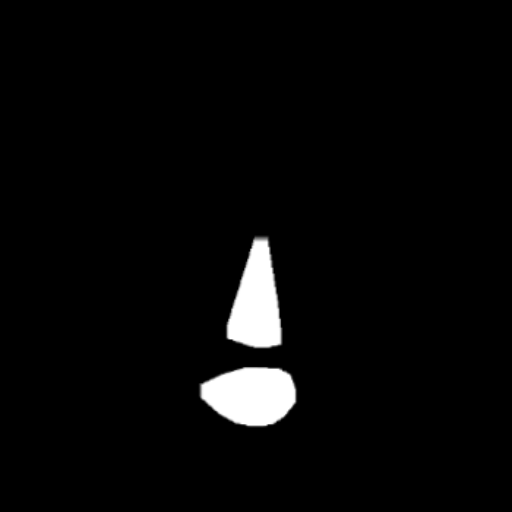

In [5]:
image, mask = validset["train"][0]["image"], validset["train"][0]["mask"]
mask

In [6]:
from src.metric import Metric
import torch
from torchvision import transforms
metric = Metric()
mask_tensor = transforms.ToTensor()(mask).unsqueeze(0)
metric.compute_iou([mask_tensor], [mask_tensor])

1.0

In [7]:
import torch


pixel_values = model.processor(image)['pixel_values'][0]
with torch.no_grad():
    outputs = model(pixel_values.unsqueeze(0), None, None, None)

In [8]:
class_queries_logits = outputs["class_queries_logits"]  # [batch_size, num_queries, num_classes]
masks_queries_logits = outputs["masks_queries_logits"]  # [batch_size, num_queries, height, width]
masks_classes = class_queries_logits.softmax(dim=-1)[..., :-1]
masks_probs = (
    masks_queries_logits.sigmoid()
)  # [batch_size, num_queries, height, width]

# Semantic segmentation logits of shape (batch_size, num_classes, height, width)
segmentation = torch.einsum("bqc, bqhw -> bchw", masks_classes, masks_probs)

In [9]:
segmentation.shape
semantic_segmentation = segmentation.argmax(dim=1)
semantic_segmentation.shape
# semantic_segmentation = [
#     semantic_segmentation[i] for i in range(semantic_segmentation.shape[0])
# ]
segmentation

tensor([[[[1.5985e-13, 1.5221e-12, 9.4170e-13,  ..., 1.9888e-14,
           6.2060e-14, 1.2356e-11],
          [4.2425e-14, 6.3967e-12, 2.3196e-12,  ..., 2.6443e-13,
           9.6309e-14, 1.4101e-11],
          [2.3616e-13, 1.0712e-11, 6.1641e-11,  ..., 6.6417e-12,
           1.2071e-12, 4.5545e-11],
          ...,
          [7.8621e-11, 1.3989e-10, 1.7641e-10,  ..., 6.6323e-09,
           1.5175e-09, 3.0719e-09],
          [1.3609e-10, 1.2757e-10, 7.2997e-11,  ..., 1.2110e-09,
           6.9700e-10, 2.4447e-09],
          [3.0175e-09, 1.7345e-09, 1.0270e-09,  ..., 3.5092e-09,
           5.1856e-09, 1.5399e-08]]]])

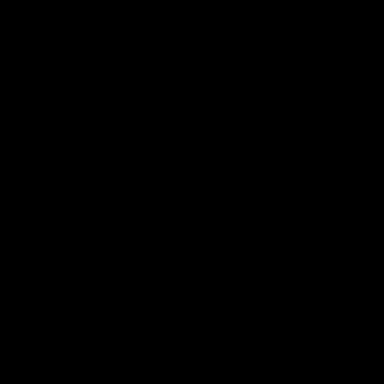

In [10]:
from PIL import Image
pred = model.processor.post_process_segmentation(
    outputs["class_queries_logits"], outputs["masks_queries_logits"]
)[0]
numpy_array = pred.numpy()
image = Image.fromarray(numpy_array * 255, mode="L")
image.show()